# base model of the architechture 

The base model consists of a VQ-VAE and PixelCNN introduced in the Neural Discrete Representation Learning (van den Oord et al, NeurIPS 2017).

The codes in this notebook are mainly adopted from the notebook created by [Amélie Royer](https://ameroyer.github.io/portfolio/2019-08-15-VQVAE/)

In [18]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt
%matplotlib inline  
print(tf.__version__)
print(K.__version__)
# has been tested to work with tensorflow version = 1.14.0 and tensorflow.keras version = 2.2.4-tf

1.14.0
2.2.4-tf


In [7]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train[..., None] / 255., y_train), (x_test[..., None] / 255., y_test)

(x_train, y_train), (x_test, y_test) = load_data('./input/mnist.npz')
print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)

Train images: (60000, 28, 28, 1)
Train labels: (60000,)


In [8]:
# Hyperparameters
NUM_LATENT_K = 20                 # Number of codebook entries
NUM_LATENT_D = 64                 # Dimension of each codebook entries
BETA = 1.0                        # Weight for the commitment loss

INPUT_SHAPE = x_train.shape[1:]
SIZE = None                       # Spatial size of latent embedding
                                  # will be set dynamically in `build_vqvae

VQVAE_BATCH_SIZE = 128            # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 20             # Number of epochs
VQVAE_LEARNING_RATE = 3e-4        # Learning rate
VQVAE_LAYERS = [16, 32]           # Number of filters for each layer in the encoder

PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block

## VQ-VAE

In [9]:

class VectorQuantizer(K.layers.Layer):  
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k
    
    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = K.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)
        
    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index
    
    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q

In [10]:
def encoder_pass(inputs, d, num_layers=[16, 32]):
    x = inputs
    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='relu', 
                            strides=(2, 2), name="conv{}".format(i + 1))(x)
    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
                          strides=(1, 1), name='z_e')(x)
    return z_e

def decoder_pass(inputs, num_layers=[32, 16]):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(2, 2), padding="SAME", 
                                     activation='relu', name="convT{}".format(i + 1))(y)
    decoded = K.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), 
                                       padding="SAME", activation='sigmoid', name='output')(y)
    return decoded

In [11]:
def build_vqvae(k, d, input_shape=(28, 28, 1), num_layers=[16, 32]):
    global SIZE
    ## Encoder
    encoder_inputs = K.layers.Input(shape=input_shape, name='encoder_inputs')
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    SIZE = int(z_e.get_shape()[1])

    ## Vector Quantization
    vector_quantizer = VectorQuantizer(k, name="vector_quantizer")
    codebook_indices = vector_quantizer(z_e)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')

    ## Decoder
    decoder_inputs = K.layers.Input(shape=(SIZE, SIZE, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
    
    ## VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
    z_q = sampling_layer(codebook_indices)
    codes = tf.stack([z_e, z_q], axis=-1)
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
    straight_through_zq = straight_through([z_q, z_e])
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')
    
    ## VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZE, SIZE), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler')
    
    ## Transition from codebook indices to model (for training the prior later)
    indices = K.layers.Input(shape=(SIZE, SIZE), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler")
    
    ## Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook')
    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook
    
    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook

vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook = build_vqvae(
    NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae.summary()

W0715 14:52:07.373061  7772 deprecation.py:506] From C:\Users\ZahraFayyaz\Anaconda3\envs\gencopy2\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 16)   160         encoder_inputs[0][0]             
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 7, 7, 32)     4640        conv1[0][0]                      
__________________________________________________________________________________________________
z_e (Conv2D)                    (None, 7, 7, 64)     18496       conv2[0][0]                      
_____________________________________________________________________________________________

In [12]:
#see equation 5.2 in the paper for more explanation:
#reconstruction loss
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss
#vector quantization loss and commitment loss
def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss    

In [14]:
def zq_norm(y_true, y_pred):
    del y_true
    _, z_q = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_q, axis=-1))

def ze_norm(y_true, y_pred):
    del y_true
    z_e, _ = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_e, axis=-1))

In [15]:
%%time
## Compile and train
vq_vae.compile(loss=[mse_loss, latent_loss], metrics={"latent_codes": [zq_norm, ze_norm]}, optimizer= K.optimizers.Adam(VQVAE_LEARNING_RATE))
history = vq_vae.fit(x_train, [x_train, None], epochs=VQVAE_NUM_EPOCHS, batch_size=VQVAE_BATCH_SIZE, verbose=2)


Wall time: 307 ms


In [ ]:
num_epochs = range(1, len(history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, history.history["loss"], label="total_loss")
plt.plot(num_epochs, history.history["decoder_loss"], label="recons_loss")
plt.plot(num_epochs, history.history["latent_codes_loss"], label="vq_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss during training")
plt.legend()
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, history.history["latent_codes_ze_norm"], label="ze_norm")
plt.plot(num_epochs, history.history["latent_codes_zq_norm"], label="zq_norm")
plt.xlabel("Epoch")
plt.ylabel("Norm")
plt.title("Codes norms during training")
plt.legend()
plt.show()

In [16]:
#alternatively one can load the model from the saved weights
vq_vae.load_weights('./weights/vq20_ws.h5')

Originals versus reconstructions


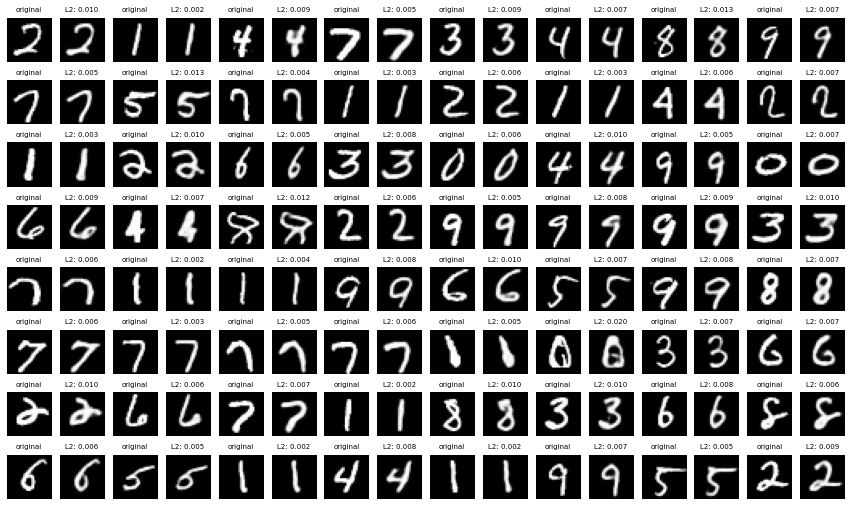

In [17]:
# original versus reconstructions
#model is able to learn a meaningful codebook and how to map images to this discrete space.
def recons(model, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    recons, _ = model.predict(x)
    dists = np.mean((recons - x)**2, axis=(1, 2, 3))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i, :, :, 0], cmap='gray')
        plt.title("original", fontsize=7)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i, :, :, 0], cmap='gray')
        plt.title("L2: {:.3f}".format(dists[i]), fontsize=7)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
recons(vq_vae, x_test, 8, 8)

## PixelCNN

In [19]:
# References:
# https://github.com/anantzoid/Conditional-PixelCNN-decoder/blob/master/layers.py
# https://github.com/ritheshkumar95/pytorch-vqvae

def gate(inputs):
    """Gated activations"""
    x, y = tf.split(inputs, 2, axis=-1)
    return Kb.tanh(x) * Kb.sigmoid(y)


class MaskedConv2D(K.layers.Layer):
    """Masked convolution"""
    def __init__(self, kernel_size, out_dim, direction, mode, **kwargs):
        self.direction = direction     # Horizontal or vertical
        self.mode = mode               # Mask type "a" or "b"
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        super(MaskedConv2D, self).__init__(**kwargs)
    
    def build(self, input_shape):   
        filter_mid_y = self.kernel_size[0] // 2
        filter_mid_x = self.kernel_size[1] // 2        
        in_dim = int(input_shape[-1])
        w_shape = [self.kernel_size[0], self.kernel_size[1], in_dim, self.out_dim]
        mask_filter = np.ones(w_shape, dtype=np.float32)
        # Build the mask
        if self.direction == "h":
            mask_filter[filter_mid_y + 1:, :, :, :] = 0.
            mask_filter[filter_mid_y, filter_mid_x + 1:, :, :] = 0.
        elif self.direction == "v":
            if self.mode == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.
            elif self.mode == 'b':
                mask_filter[filter_mid_y+1:, :, :, :] = 0.0
        if self.mode == 'a':
            mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        # Create convolution layer parameters with masked kernel
        self.W = mask_filter * self.add_weight("W_{}".format(self.direction), w_shape, trainable=True)
        self.b = self.add_weight("v_b", [self.out_dim,], trainable=True)
    
    def call(self, inputs):
        return K.backend.conv2d(inputs, self.W, strides=(1, 1)) + self.b

    
def gated_masked_conv2d(v_stack_in, h_stack_in, out_dim, kernel, mask='b', residual=True, i=0):
    """Basic Gated-PixelCNN block. 
       This is an improvement over PixelRNN to avoid "blind spots", i.e. pixels missingt from the
       field of view. It works by having two parallel stacks, for the vertical and horizontal direction, 
       each being masked  to only see the appropriate context pixels.
    """
    kernel_size = (kernel // 2 + 1, kernel)
    padding = (kernel // 2, kernel // 2)
        
    v_stack = K.layers.ZeroPadding2D(padding=padding, name="v_pad_{}".format(i))(v_stack_in)
    v_stack = MaskedConv2D(kernel_size, out_dim * 2, "v", mask, name="v_masked_conv_{}".format(i))(v_stack)
    v_stack = v_stack[:, :int(v_stack_in.get_shape()[-3]), :, :]
    v_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="v_gate_{}".format(i))(v_stack)
    
    kernel_size = (1, kernel // 2 + 1)
    padding = (0, kernel // 2)
    h_stack = K.layers.ZeroPadding2D(padding=padding, name="h_pad_{}".format(i))(h_stack_in)
    h_stack = MaskedConv2D(kernel_size, out_dim * 2, "h", mask, name="h_masked_conv_{}".format(i))(h_stack)
    h_stack = h_stack[:, :, :int(h_stack_in.get_shape()[-2]), :]
    h_stack_1 = K.layers.Conv2D(filters=out_dim * 2, kernel_size=1, strides=(1, 1), name="v_to_h_{}".format(i))(v_stack)
    h_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="h_gate_{}".format(i))(h_stack + h_stack_1)
    
    h_stack_out =  K.layers.Conv2D(filters=out_dim, kernel_size=1, strides=(1, 1), name="res_conv_{}".format(i))(h_stack_out)
    if residual:
        h_stack_out += h_stack_in
    return v_stack_out, h_stack_out


In [20]:
# Dataset to train the Prior
z_train = encoder.predict(x_train)
z_train.shape

KeyboardInterrupt: 

In [ ]:
# original versus reconstructions
def viz_codes(encoder, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    codes = encoder.predict(x)
    fig = plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2*i+1)
        plt.imshow(x[i,:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2*i+2)
        plt.pcolor(codes[i, ::-1, :], cmap='tab10') #flip y-axis origin to match imshow
        plt.axis('off')
    cbaxes = fig.add_axes([0.92, 0.15, 0.015, 0.7]) 
    cb = plt.colorbar(cax=cbaxes)  
    plt.show()
    
    
print("Images encoded as discrete codes")
viz_codes(encoder, x_test, 8, 8)

In [35]:
def build_pixelcnn(codes_sampler, k, size, num_layers, num_feature_maps=32):
    pixelcnn_prior_inputs = K.layers.Input(shape=(size, size), name='pixelcnn_prior_inputs', dtype=tf.int32)
    z_q = codes_sampler(pixelcnn_prior_inputs) # maps indices to the actual codebook
    
    v_stack_in, h_stack_in = z_q, z_q
    for i in range(num_layers):
        mask = 'b' if i > 0 else 'a'
        kernel_size = 3 if i > 0 else 7
        residual = True if i > 0 else False
        v_stack_in, h_stack_in = gated_masked_conv2d(v_stack_in, h_stack_in, num_feature_maps,
                                                     kernel=kernel_size, residual=residual, i=i + 1)

    fc1 = K.layers.Conv2D(filters=num_feature_maps, kernel_size=1, name="fc1")(h_stack_in)
    fc2 = K.layers.Conv2D(filters=k, kernel_size=1, name="fc2")(fc1) 
    # outputs logits for probabilities of codebook indices for each cell

    pixelcnn_prior = K.Model(inputs=pixelcnn_prior_inputs, outputs=fc2, name='pixelcnn-prior')

    # Distribution to sample from the pixelcnn
    dist = tf.distributions.Categorical(logits=fc2)
    sampled = dist.sample()
    prior_sampler = K.Model(inputs=pixelcnn_prior_inputs, outputs=sampled, name='pixelcnn-prior-sampler')
    return pixelcnn_prior, prior_sampler

pixelcnn_prior, prior_sampler = build_pixelcnn(codes_sampler, NUM_LATENT_K, SIZE, 
                                               PIXELCNN_NUM_BLOCKS, PIXELCNN_NUM_FEATURE_MAPS)
pixelcnn_prior.summary()

Model: "pixelcnn-prior"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pixelcnn_prior_inputs (InputLay [(None, 7, 7)]       0                                            
__________________________________________________________________________________________________
codes_sampler (Model)           (None, 7, 7, 64)     0           pixelcnn_prior_inputs[0][0]      
__________________________________________________________________________________________________
v_pad_1 (ZeroPadding2D)         (None, 13, 13, 64)   0           codes_sampler[2][0]              
__________________________________________________________________________________________________
h_pad_1 (ZeroPadding2D)         (None, 7, 13, 64)    0           codes_sampler[2][0]              
_____________________________________________________________________________________

__________________________________________________________________________________________________
v_gate_7 (Lambda)               (None, 7, 7, 32)     0           tf_op_layer_strided_slice_38[0][0
__________________________________________________________________________________________________
tf_op_layer_add_35 (TensorFlowO [(None, 7, 7, 32)]   0           res_conv_7[0][0]                 
                                                                 tf_op_layer_add_33[0][0]         
__________________________________________________________________________________________________
v_pad_8 (ZeroPadding2D)         (None, 9, 9, 32)     0           v_gate_7[0][0]                   
__________________________________________________________________________________________________
h_pad_8 (ZeroPadding2D)         (None, 7, 9, 32)     0           tf_op_layer_add_35[0][0]         
__________________________________________________________________________________________________
v_masked_c

In [26]:

# Train the PixelCNN and monitor prediction accuracy
def accuracy(y_true, y_pred):
    size = int(y_pred.get_shape()[-2])
    k = int(y_pred.get_shape()[-1])
    y_true = tf.reshape(y_true, (-1, size * size))
    y_pred = tf.reshape(y_pred, (-1, size * size, k))
    return Kb.cast(Kb.equal(y_true, Kb.cast(Kb.argmax(y_pred, axis=-1), Kb.floatx())), Kb.floatx())

pixelcnn_prior.compile(loss=K.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[accuracy],
                       optimizer=K.optimizers.Adam(PIXELCNN_LEARNING_RATE))



Wall time: 136 ms


In [ ]:
%%time
prior_history = pixelcnn_prior.fit(z_train, z_train, epochs=PIXELCNN_NUM_EPOCHS, 
                                   batch_size=PIXELCNN_BATCH_SIZE, verbose=1)

In [ ]:
num_epochs = range(1, len(prior_history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, prior_history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, prior_history.history["accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training")
plt.show()

In [40]:
#alternatively one can load the model from the saved weights
pixelcnn_prior.load_weights('./weights/pixelcnn20ws.h5')

Originals versus reconstructions


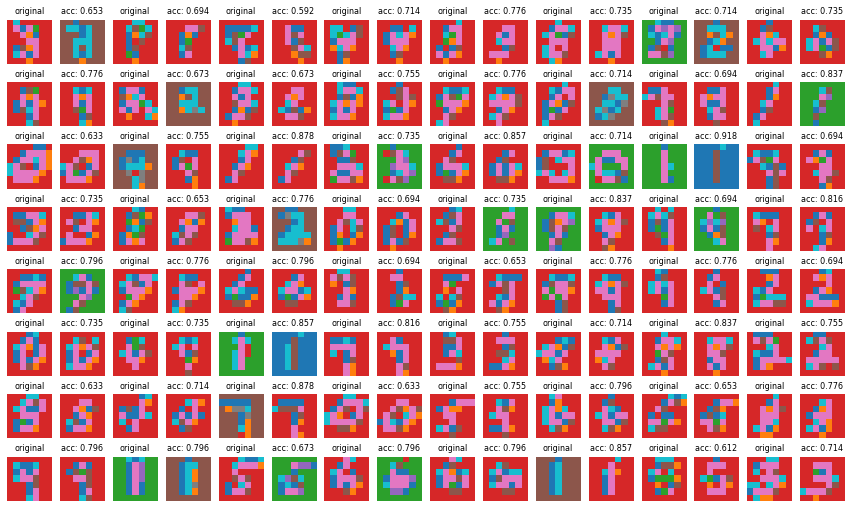

In [28]:
def recons_prior(model, z, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(z.shape[0], size=n, replace=False)
        x = z[x]
    else:
        x = z[:n]
    recons = model.predict(x)
    recons = np.argmax(recons, axis=-1)
    accs = np.mean(np.equal(recons, x), axis=(1, 2))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i], cmap='tab10')
        plt.title("original", fontsize=8)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i], cmap='tab10')
        plt.title("acc: {:.3f}".format(accs[i]), fontsize=8)
        plt.axis('off')
    plt.show()

#this would corespond to reconstruction with full attention
print("Originals versus reconstructions")
z_test = encoder.predict(x_test)
recons_prior(pixelcnn_prior, z_test, 8, 8)

Random codes sampled from the prior and correspopnding decoded images


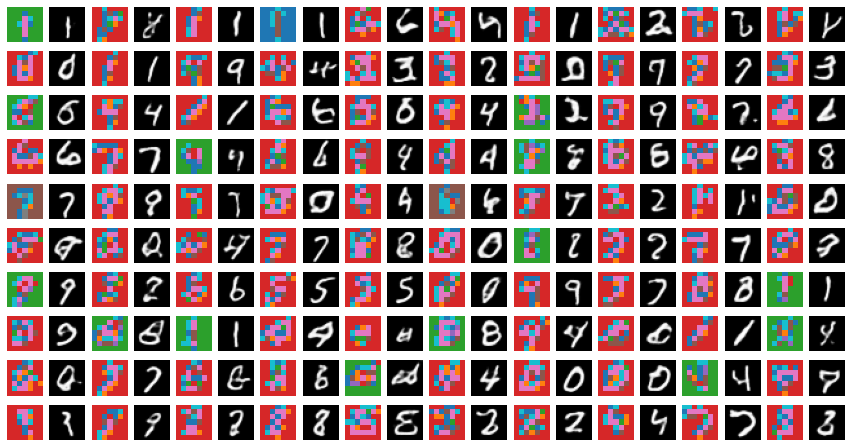

In [29]:
def sample_from_prior(prior, shape):
    """sample from the PixelCNN prior, pixel by pixel"""
    global prior_sampler
    X = np.zeros(shape, dtype=np.int32)
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            sampled = prior_sampler.predict(X)
            X[:, i, j] = sampled[:, i, j]
    return X
            
    
def generate(prior, codes_sampler, size, n_row, n_col):
    """Generate random images by sampling codes from the given prior"""
    n = n_col * n_row
    indices = sample_from_prior(prior, (n, size, size))
    zq = codes_sampler(indices)
    generated = decoder.predict(zq, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(indices[i], cmap='tab10')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()

#This would correspond to zero attention and dreaming images from scratch. See the first panel in Fig.5 of the paper    
print("Random codes sampled from the prior and correspopnding decoded images")
generate(prior_sampler, codes_sampler, SIZE, 10, 10)

In [64]:
#these functions discard part of the unattended latent attention and then fills in the discarded parts with the help of semantic knowledge of the Pixelcnn network

def crop(index_matrix,index):
    """Crop function discards all parts of the index matrix after the given index.
    It assumes that the index matrix is 7*7 and index can be an integer between 0 and 49""" 
    line=int(index/7)
    col=np.remainder(index,7)
    cropped= np.zeros(index_matrix.shape)
    cropped[:,:line,:]=index_matrix[:,:line,:]
    cropped[:,line,:col]=index_matrix[:,line,:col]
    return cropped.astype('int64')    

def completecodes(index_matrix, index):
    """completes the index matrix after the given index value"""
    
    global prior_sampler
    X = index_matrix
    line=int(index/7)
    col=np.remainder(index,7)

    for i in range(line,X.shape[1]):
        if i==line and col>0:
            for j in range(col,X.shape[2]):
                sampled = prior_sampler.predict(X)
                X[:, i, j] = sampled[:, i, j] 
        else:
            for j in range(X.shape[2]):
                sampled = prior_sampler.predict(X)
                X[:, i, j] = sampled[:, i, j] 
                
    return X.astype(int)


def decode(codes, codes_sampler,x_test, size, n_row, n_col):
    """plot decoded codes"""
    n = n_col * n_row
    zq = codes_sampler(codes)
    decoded = decoder.predict(zq, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x_test[i], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(decoded[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    


### Figure 5 of the paper
set the attention to any level between 0 and 49 to produce samples shown in figure 5. The odd columns show the original inputs and the even columns show the coresponding reconstructions with the given attention.

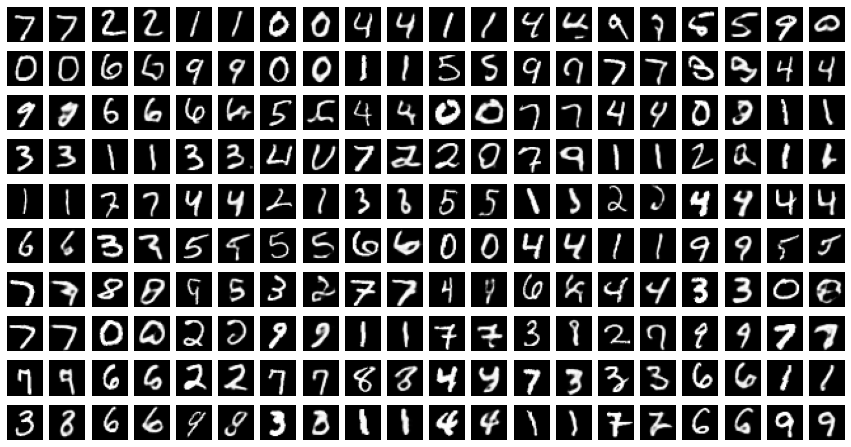

In [41]:
attention_level=20 #set between 0 and 49
decode(completecodes(z_test[0:100],attention_level),codes_sampler,x_test[0:100],100,10,10)

### Figure 6 of the paper
for figure 6 we need a classifier to find the statistics of the results.
A pretrained weak and strong pixelcnn (semantic completion network) is loaded here. 

In [51]:
from keras.models import load_model
classifier= load_model('./weights/MNIST_keras_CNN.h5') #pretrained classifier on mnist with accuracy 99%

def correctclass(decoded):
    """returns percentage of correctly classifies test data"""
    pred=classifier.predict(decoded)
    preds=np.argmax(pred, axis=1)
    correct=(preds == y_test[:decoded.shape[0]]).mean()
    return correct

def attention(z, index):
    """returns the decoded digits with a certain attention level(index)"""
    cropped=crop(z,index)
    completed=completecodes(cropped, index)
    zq = codes_sampler(completed)
    decoded = decoder.predict(zq, steps=1)
    return decoded


C:\Users\ZahraFayyaz\Anaconda3\envs\gencopy2\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [66]:
#No semantic completion network 
#The index matrix is cropped but not completed with the help of semantic network 
attention_level=20 #set between 0 and 49
attention_percentage= round(100*attention_level/49,2)
zq = codes_sampler(crop(z_test,attention_level))
decoded = decoder.predict(zq, steps=1)
accuracy = correctclass(decoded)
print('accuracy at attention level',"Percentage: {}%".format(attention_percentage),'is', accuracy)

accuracy at attention level Percentage: 40.82% is 0.2795


In [54]:
#Weak semantic completion network 
#The completion process takes a while for the full test set. Alternatively you can calculate statistics only on part of the data.
pixelcnn_prior.load_weights('./weights/weights-03-0.75.hdf5') 
attention_level=20 #set between 0 and 49
attention_percentage= round(100*attention_level/49,2)
accuracy = correctclass(attention(z_test,attention_level))
print('accuracy at attention level',"Percentage: {}%".format(attention_percentage),'is', accuracy)

In [ ]:
#Strong semantic completion network 
pixelcnn_prior.load_weights('./weights/weights-40-0.65.hdf5') 
attention_level=20 #set between 0 and 49
attention_percentage= round(100*attention_level/49,2)
accuracy = correctclass(attention(z_test,attention_level))
print('accuracy at attention level',"Percentage: {}%".format(attention_percentage),'is', accuracy)